In [1]:
import pandas as pd
import numpy as np
import math
import statsmodels.api as sm
import matplotlib.pyplot as plt
import random
import pmdarima
#from google.colab import drive
#drive.mount('/content/drive')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Mounted at /content/drive


In [2]:
#aggregating case dataset
files = ['2003_malaria_bse_totsp.csv', '2004_malaria_bse_totsp.csv', '2005_malaria_bse_totsp.csv', '2006_malaria_bse_totsp.csv', '2007malaria_bse_totsp.csv', '2008_malaria_bse_totsp.csv', '2009_malaria_bse_totsp.csv']
#dir = '/content/drive/Shareddrives/ProjectX 2021/data/RAW ODISHA MALARIA DATA/Malaria_2003-2013_Odisha/'
dir = './data/RAW ODISHA MALARIA DATA/Malaria_2003-2013_Odisha/'

series = []
for f in files:
    df = pd.read_csv(dir + f)
    months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    counts = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    for index, row in df.iterrows():
        for i in range(len(months)):
            if row['mnth'] == months[i]:
                if math.isnan(row['totsp']):
                    continue
                else:     
                    counts[i] += row['totsp']
    for c in counts:
        series.append(c)
files = ['2010_malaria_bse_totsp.csv', '2011_malaria_bse_totsp.csv', '2012_malaria_bse_totsp.csv', '2013_malaria1_bse_totsp.csv']
for f in files:
    df = pd.read_csv(dir + f)
    months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    counts = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    curr_year = f[0:4]
    for index, row in df.iterrows():
        for i in range(len(months)):
            if row['Month'] == months[i]:
                if int(curr_year) == 2010 or int(curr_year) == 2013:
                  if math.isnan(row['TOTSP']):
                      continue
                  else:     
                      counts[i] += row['TOTSP']
                else:
                  if math.isnan(row['Totsp']):
                      continue
                  else:     
                      counts[i] += row['Totsp']
    for c in counts:
        series.append(c)

In [ ]:
print(len(series))

132


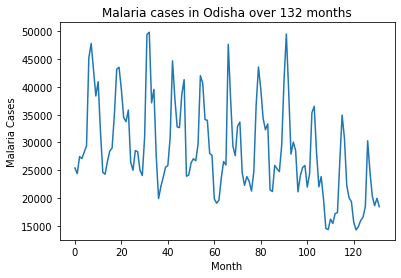

In [ ]:
plt.plot(series)
plt.xlabel('Month')
plt.ylabel('Malaria Cases')
plt.title('Malaria cases in Odisha over 132 months')
plt.show()

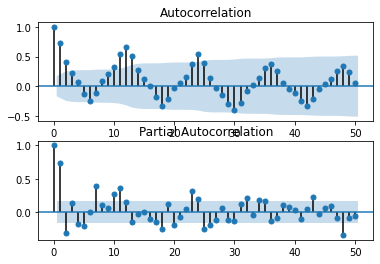

           0
0    25405.0
1    24394.0
2    27452.0
3    27101.0
4    28229.0
..       ...
127  24659.0
128  20330.0
129  18614.0
130  19951.0
131  18424.0

[132 rows x 1 columns]
          0
0       NaN
1   -1011.0
2    3058.0
3    -351.0
4    1128.0
..      ...
127 -5645.0
128 -4329.0
129 -1716.0
130  1337.0
131 -1527.0

[132 rows x 1 columns]


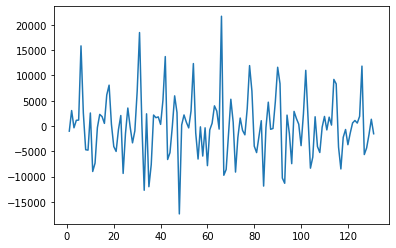

In [3]:
df = pd.DataFrame(series)
df_diff = df.diff(periods = 1)
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(df, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(df, lags=50, ax=ax[1])
plt.show()
print(df)
print(df_diff)
plt.plot(df_diff)

In [ ]:
#initial grid search of parameters
min_err = -34.419604580968404
best_params = [1, 1, 7, 1, 1, 0]
for i in [2, 3, 4, 5, 6, 7]:
  for j in [1, 2, 3, 4, 5, 6, 7]:
    for k in [1, 2, 3, 4, 5, 6, 7]:
      for l in [1, 2, 3, 4, 5, 6, 7]:
        model=sm.tsa.statespace.SARIMAX(endog=series,order=(i,j,k),seasonal_order=(1,l,0,12),trend='c',enforce_invertibility=False,enforce_stationarity=False)
        model_fit = model.fit()
        # summary of fit model
        # print(model_fit.summary())
        # line plot of residuals
        residuals = pd.DataFrame(model_fit.resid)
        # residuals.plot()
        # plt.show()
        # # density plot of residuals
        # residuals.plot(kind='kde')
        # plt.show()
        # summary stats of residuals
        # print(residuals.mean(axis=0).item())
        print([i, j, k, l])
        if abs(min_err) > abs(residuals.mean(axis=0).item()):
          min_err = residuals.mean(axis=0).item()
          best_params = [i, j, k, 1, l, 0]
print(best_params)

In [ ]:
print(best_params)
print(min_err)

[2, 1, 3, 1, 2, 0]
10.110049700003621


In [ ]:
#using autoarima for parameter fine-tuning
model_autoarima = pmdarima.auto_arima(df['Malaria_Cases'], seasonal=True,m=12)

In [4]:
def one_step_forecast(data, n_test):
    train, test = data[:n_test], data[n_test:]

    # Fit model to training data
    model = sm.tsa.statespace.SARIMAX(endog=train,order=(2,1,1),seasonal_order=(1,0,1,12),trend='c',enforce_invertibility=False,enforce_stationarity=False).fit(max_iter = 50, method = 'powell')
    
    forecast = model.forecast()

    return (abs(test[0]-forecast)/test[0])*100

In [ ]:
errs = []
for i in range(0, 100):
  end = random.randint(60, 130)
  errs.append(one_step_forecast(series[end-60:end+1], 60))

In [6]:
#mean
sum = 0
for i in errs:
  sum += i[0]
print(sum/len(errs))

9.940927428172724


In [7]:
#median 
errs.sort()
print(errs[int(len(errs)/2)])

[8.59393182]


In [13]:
#standard deviation
mean = np.sum(errs)/ len(errs)
variance = np.sum([((x - mean) ** 2) for x in errs]) / len(errs)
res = variance ** 0.5
print(res)

7.50264856119629
